In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Replace 'your_file.csv' with the name of your CSV file
csv_file_path = 'game_data/game_data_public.DSK.PremierDraft.csv.gz'
output_file_path = 'first_few_rows_DSK.csv'
# Read the CSV file
df = pl.scan_csv(csv_file_path)

# Get the first few rows
first_few_rows = df.head(30).collect()

# Write the first few rows to a new CSV file
first_few_rows.write_csv(output_file_path)




In [2]:


def card_wr(card, df):
    # Collect schema names to avoid performance warnings
    column_names = df.collect_schema().names()
    
    # Select relevant columns
    columns = [col for col in column_names if col.startswith(f"opening_hand_{card}") or col.startswith(f"drawn_{card}") or col.startswith(f"tutored_{card}") or col.startswith(f"deck_{card}") or col.startswith(f"sideboard_{card}") or col == "won"]
    df_card = df.select(columns)
    
    # Rename columns
    df_card = df_card.rename({col: col.replace(f"_{card}", "") for col in columns})
    
    # Filter decks that played the card
    df_card = df_card.filter(pl.col("deck") > 0)
    
    # Add stats
    df_card = df_card.with_columns([
        (pl.col("opening_hand") + pl.col("drawn")).alias("game_in_hand"),
        #(pl.col("opening_hand") + pl.col("drawn") + pl.col("tutored")).alias("game_seen"),
        #(pl.col("deck") - (pl.col("opening_hand") + pl.col("drawn") + pl.col("tutored"))).alias("game_not_seen")
    ])
    
    # Adjust Number of Games Not Seen
    # df_card = df_card.with_columns([
    #     pl.when(pl.col("game_not_seen") < 0).then(0).otherwise(pl.col("game_not_seen")).alias("game_not_seen")
    # ])
    
    # Calculate win rates
    df_card = df_card.with_columns([
        (pl.col("opening_hand") * pl.col("won")).alias("opening_hand_win"),
        (pl.col("deck") * pl.col("won")).alias("game_played_win"),
        (pl.col("game_in_hand") * pl.col("won")).alias("game_in_hand_win"),
        #(pl.col("game_not_seen") * pl.col("won")).alias("game_not_seen_win")
    ])
    
    # Summarize statistics
    summary = df_card.select([
        pl.lit(card).alias("card"),
        #pl.sum("deck").alias("games_played_n"),
        (pl.sum("game_played_win") / pl.sum("deck")).alias("game_played_wr"),
        #pl.sum("opening_hand").alias("opening_hand_n"),
        (pl.sum("opening_hand_win") / pl.sum("opening_hand")).alias("opening_hand_wr"),
        #pl.sum("game_in_hand").alias("game_in_hand_n"),
        (pl.sum("game_in_hand_win") / pl.sum("game_in_hand")).alias("game_in_hand_wr"),
        #pl.sum("game_not_seen").alias("game_not_seen_n"),
        #(pl.sum("game_not_seen_win") / pl.sum("game_not_seen")).alias("game_not_seen_wr"),
        #(pl.sum("game_in_hand_win") / pl.sum("game_in_hand") - pl.sum("game_not_seen_win") / pl.sum("game_not_seen")).alias("iwd")
    ])
    
    return summary.collect()


pl.Config(fmt_str_lengths=1000, tbl_width_chars=1000)
pl.Config(tbl_cols=-1)



card_stats = card_wr("Winter's Intervention", df)

print(card_stats)
print(card_wr)






shape: (1, 4)
┌───────────────────────┬────────────────┬─────────────────┬─────────────────┐
│ card                  ┆ game_played_wr ┆ opening_hand_wr ┆ game_in_hand_wr │
│ ---                   ┆ ---            ┆ ---             ┆ ---             │
│ str                   ┆ f64            ┆ f64             ┆ f64             │
╞═══════════════════════╪════════════════╪═════════════════╪═════════════════╡
│ Winter's Intervention ┆ 0.531758       ┆ 0.537638        ┆ 0.548453        │
└───────────────────────┴────────────────┴─────────────────┴─────────────────┘
<function card_wr at 0x1699fc3a0>


In [3]:
# def compute_and_cache_stats(df, card_list):
#     cached_stats = []  # List to store the stats for each card
    
#     # Loop through each card and calculate stats
#     for card in card_list[:4]:
#         stats = card_wr(card, df)
#         cached_stats.append(stats.to_pandas())
#         print("finished ", card )

#     # Combine the results into a single DataFrame
#     combined_stats = pd.concat(cached_stats, ignore_index=True)
    
#     return combined_stats

# compute_and_cache_stats(df, card_names).to_csv('cached_stats.csv')


In [11]:

def compute_wr_for_all_cards(df, card_list):
    # Convert to LazyFrame for efficiency
    df_lazy = df.lazy()

    # Collect column names once
    column_names = df.schema.keys()

    # Prepare a list of dataframes for each card
    summaries = []

    for card in card_list:
        # Select relevant columns dynamically
        columns = [col for col in column_names if col.startswith(f"opening_hand_{card}") or 
                   col.startswith(f"drawn_{card}") or 
                   col.startswith(f"deck_{card}") or 
                   col == "won"]
        
        if not columns:
            continue  # Skip if no relevant columns exist for this card

        df_card = df_lazy.select(columns)

        # Rename columns to a standard format
        rename_map = {col: col.replace(f"_{card}", "") for col in columns}
        df_card = df_card.rename(rename_map)

        # Filter decks that played the card
        df_card = df_card.filter(pl.col("deck") > 0)

        # Compute **game_in_hand**
        df_card = df_card.with_columns(
            (pl.col("opening_hand") + pl.col("drawn")).alias("game_in_hand")
        )

        # Compute win rate components
        df_card = df_card.with_columns([
            (pl.col("opening_hand") * pl.col("won")).alias("opening_hand_win"),
            (pl.col("deck") * pl.col("won")).alias("game_played_win"),
            (pl.col("game_in_hand") * pl.col("won")).alias("game_in_hand_win"),
        ])

        # Summarize statistics efficiently
        summary = df_card.select([
            pl.lit(card).alias("name"),
            (pl.sum("game_played_win") / pl.sum("deck")).alias("game_played_wr"),
            (pl.sum("opening_hand_win") / pl.sum("opening_hand")).alias("opening_hand_wr"),
            (pl.sum("game_in_hand_win") / pl.sum("game_in_hand")).alias("game_in_hand_wr"),
        ])

        summaries.append(summary)

    # Combine all summaries into a single dataframe
    final_df = pl.concat(summaries).collect()

    return final_df

In [ ]:
# run sparingly, this is the big time function

want_to_run = False

if want_to_run:
    card_names = pl.read_csv("DSK_color_data.csv")["name"].tolist()
    stats_df = compute_wr_for_all_cards(df, card_names)
    color_df = pl.read_csv("DSK_color_data.csv")
    combined = color_df.join(stats_df, on='name', how='inner')
    combined.write_csv("DSK_data_combined.csv")


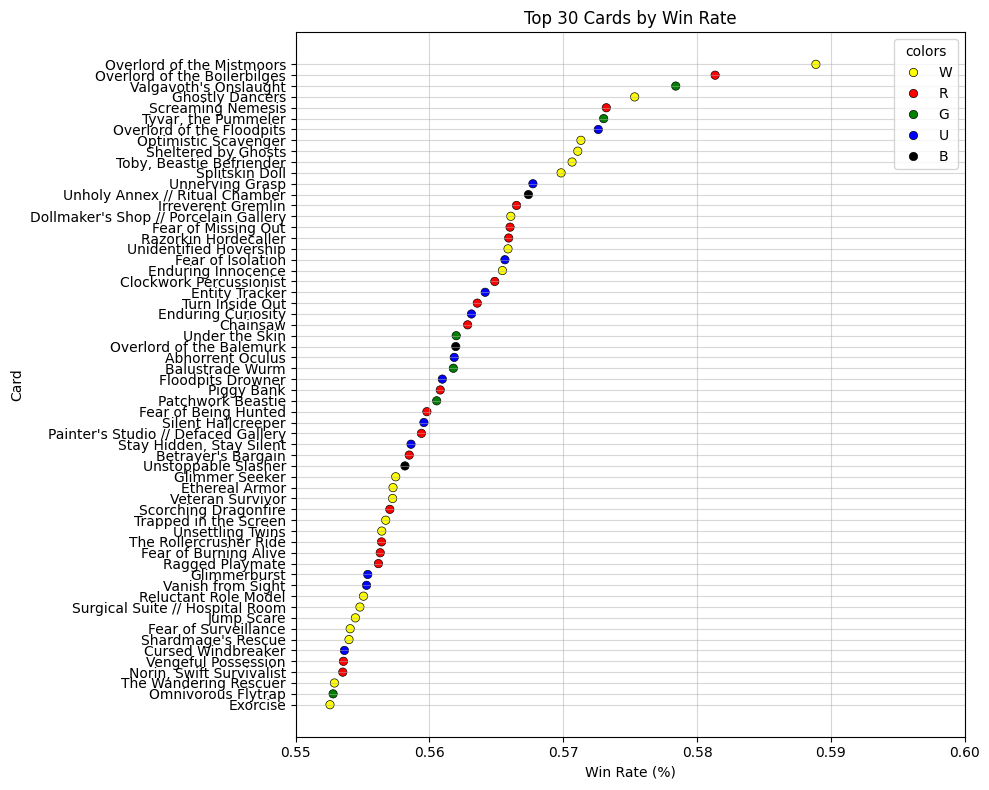

In [ ]:
# top30 = wrdf.sort_values(by='game_played_wr', ascending=False).head(30)
combined = pd.read_csv('DSK_data_combined.csv')

red = combined[combined['colors'].isin(['R'])]
blue = combined[combined['colors'].isin(['U'])]
green = combined[combined['colors'].isin(['G'])]
white = combined[combined['colors'].isin(['W'])]
black = combined[combined['colors'].isin(['B'])]
redblue = pd.concat([red, blue, green, white, black]).sort_values(by='game_played_wr', ascending=False).head(0)

plt.figure(figsize=(10, 8))

# Scatter plot: Card names on the Y-axis, win rates on the X-axis
sns.scatterplot(data=redblue, 
                x='game_played_wr',
                 y='name', 
                 marker='o', 
                 palette={'R': 'red', 'U': 'blue', 'G': 'green','W': 'yellow',"B": 'black'}, 
                 hue='colors',
                 edgecolors='black',)

# Set labels and title
plt.xlabel('Win Rate (%)')
plt.xlim(.55,.6)
plt.ylabel('Card')
plt.title('Top 30 Cards by Win Rate')
plt.grid(True,alpha=0.5)

# Optionally, you can adjust plot aesthetics (e.g., adjust size, style)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# churn out data for mono-color cards based on color pairs


want_to_run = True

if want_to_run:
    color_df = pl.read_csv("DSK_color_data.csv")
    valid_color_pairs = ['WU', 'UB', 'BR', 'RG', 'WG', 'WB', 'BG', 'UG', 'UR', 'WR']

    for color_pair in valid_color_pairs:
        color_pair_df = df.filter(pl.col("main_colors") == color_pair)
        color_card_names = color_df.filter(pl.col("color_pairs").str.contains(color_pair))['name'].to_list()
        color_stats_df = compute_wr_for_all_cards(color_pair_df, color_card_names)
        combined = color_df.join(color_stats_df, on="name", how="inner")
        combined.write_csv(f"DSK_color/DSK_{color_pair}_win_rates.csv")
        print("finished ", color_pair)
        del color_pair_df
        del color_card_names
        del color_stats_df
        del combined



     

/var/folders/0c/w91k3rpx5qn5ww7xr_n5y0y40000gn/T/ipykernel_9824/1489300626.py:6: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  column_names = df.schema.keys()


finished  UG
finished  WG
finished  WR


In [ ]:
# top30 = wrdf.sort_values(by='game_played_wr', ascending=False).head(30)
combined = pd.read_csv('DSK_data_combined.csv')

red = combined[combined['colors'].isin(['R'])]
blue = combined[combined['colors'].isin(['U'])]
green = combined[combined['colors'].isin(['G'])]
white = combined[combined['colors'].isin(['W'])]
black = combined[combined['colors'].isin(['B'])]
top30 = pd.concat([red, blue, green, white, black]).sort_values(by='game_in_hand_wr', ascending=False).head(50)

valid_color_pairs = ['WU', 'UB', 'BR', 'RG', 'WG', 'WB', 'BG', 'UG', 'UR', 'WR']
for color_pair in valid_color_pairs:
    color_pair_df = pd.read_csv(f"DSK_color/DSK_{color_pair}_win_rates.csv")
    top30 = top30.merge(color_pair_df[['name','game_in_hand_wr']],
                        how='left',
                        on='name',
                        suffixes=('', f'_{color_pair}'))


top30.to_csv('DSK_color/DSK_top30.csv')
print(top30)


                                     name colors  color_pairs  game_played_wr  \
0               Overlord of the Mistmoors      W  WU,WG,WB,WR        0.588884   
1                   Valgavoth's Onslaught      G  RG,WG,BG,UG        0.578408   
2          Unholy Annex // Ritual Chamber      B  UB,BR,WB,BG        0.567396   
3                         Ghostly Dancers      W  WU,WG,WB,WR        0.575338   
4            Overlord of the Boilerbilges      R  BR,RG,UR,WR        0.581353   
5               Overlord of the Floodpits      U  WU,UB,UG,UR        0.572619   
6                     Tyvar, the Pummeler      G  RG,WG,BG,UG        0.573022   
7   Dollmaker's Shop // Porcelain Gallery      W  WU,WG,WB,WR        0.566081   
8                Overlord of the Balemurk      B  UB,BR,WB,BG        0.561966   
9                     Sheltered by Ghosts      W  WU,WG,WB,WR        0.571086   
10                      Screaming Nemesis      R  BR,RG,UR,WR        0.573220   
11                    Unstop

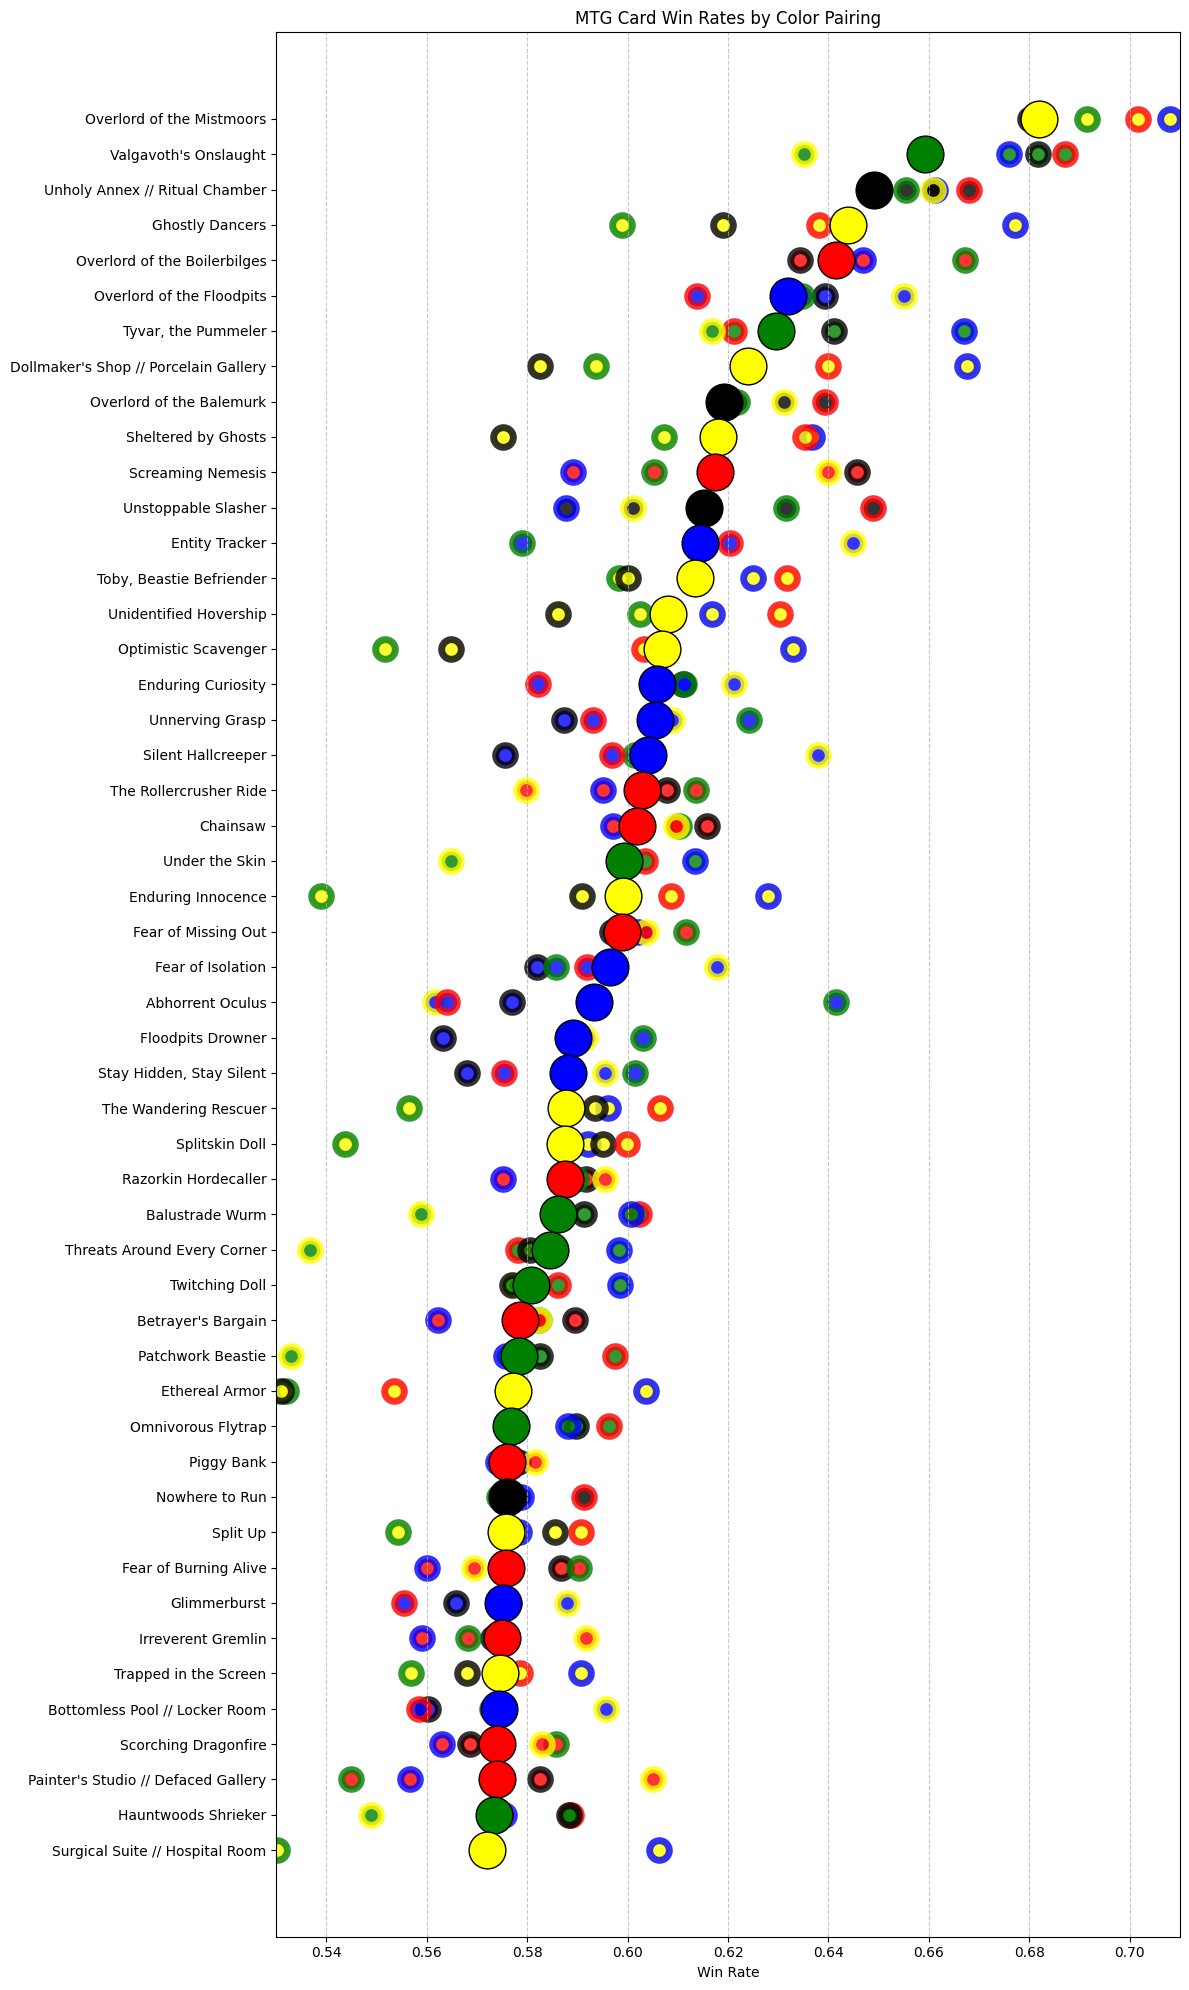

In [86]:



# Convert to pandas for easier plotting
df_pandas = pd.DataFrame(top30)

# Create a color mapping dictionary
color_map = {
    'W': 'yellow',
    'U': 'blue',
    'B': 'black',
    'R': 'red',
    'G': 'green'
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12,20))

# Iterate through each row in the DataFrame
for idx, row in df_pandas.iterrows():
    card_name = row['name']
    card_color = row['colors']
    
    # Get the inner color based on the card's color
    inner_color = color_map.get(card_color, 'darkgray')
    
    # Plot the general win rate
    if pd.notna(row['game_in_hand_wr']):
        ax.scatter(row['game_in_hand_wr'], idx, 
                  color=inner_color, 
                  s=700,
                  zorder=2,
                  edgecolors='black',
                  label='General WR' if idx == 0 else "")
    
    # Plot win rates for each color pairing
    for col in df_pandas.columns:
        if col.startswith('game_in_hand_wr_') and pd.notna(row[col]):
            # Get the color pairing from the column name
            color_pairing = col.replace('game_in_hand_wr_', '')
            
            # Determine the edge color based on the card's color and the pairing
            if len(color_pairing) == 2:
                color1, color2 = color_pairing[0], color_pairing[1]
                
                # If the card is one of the colors in the pairing, use the other color
                if card_color == color1:
                    edge_color = color_map.get(color2)
                elif card_color == color2:
                    edge_color = color_map.get(color1)
                else:
                    # Skip this pairing if the card color isn't in the pairing
                    continue
            else:
                # Skip invalid pairings
                continue
            
            # Only plot if we have a valid edge color
            if edge_color:
                ax.scatter(row[col], idx, 
                          color=inner_color, 
                          edgecolor=edge_color,
                          s=200,
                          alpha=0.8,
                          linewidth=5,
                          zorder=1,
                          label=color_pairing if idx == 0 else "")

# Add card names to the y-axis
plt.yticks(range(len(df_pandas)), df_pandas['name'])

ax.invert_yaxis()

# Set the x-axis limits
plt.xlim(0.53, 0.71)

# Add labels and title
plt.xlabel('Win Rate')
plt.title('MTG Card Win Rates by Color Pairing')

# Add gridlines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout to make room for card names
plt.tight_layout()

# Show the plot
plt.show()

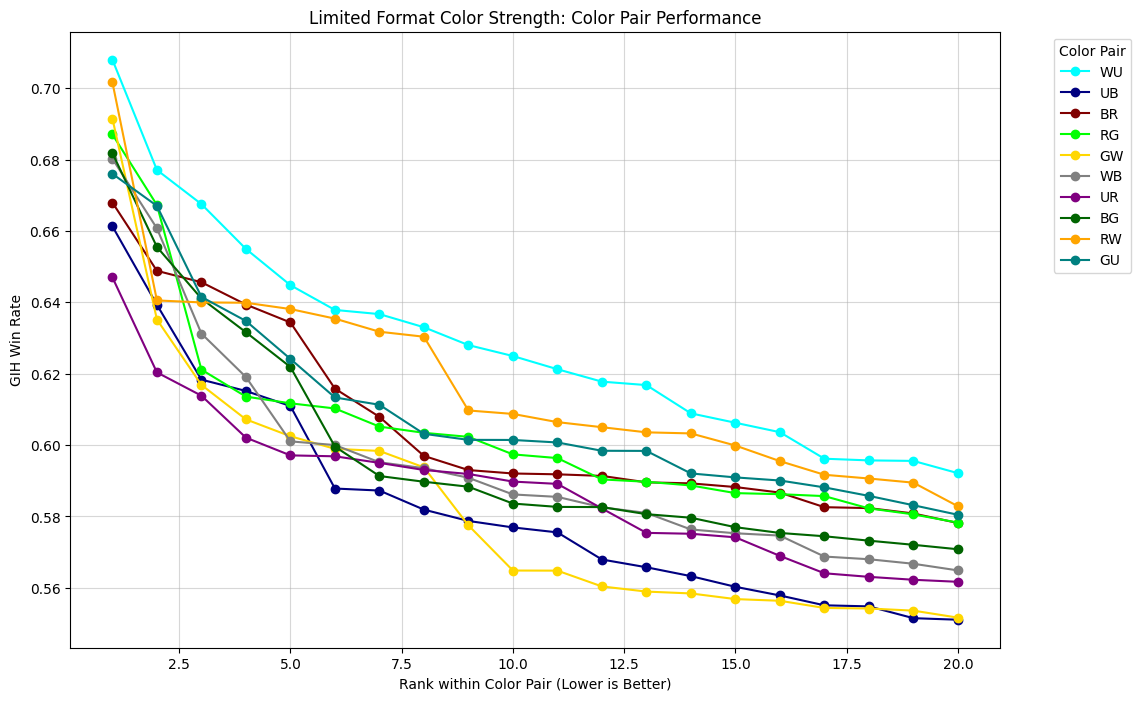

: 

In [ ]:

# Manually load color pair CSVs
df_wu = pd.read_csv("DSK_color/DSK_WU_win_rates.csv")
df_ub = pd.read_csv("DSK_color/DSK_UB_win_rates.csv")
df_br = pd.read_csv("DSK_color/DSK_BR_win_rates.csv")
df_rg = pd.read_csv("DSK_color/DSK_RG_win_rates.csv")
df_gw = pd.read_csv("DSK_color/DSK_WG_win_rates.csv")
df_wb = pd.read_csv("DSK_color/DSK_WB_win_rates.csv")
df_ur = pd.read_csv("DSK_color/DSK_UR_win_rates.csv")
df_bg = pd.read_csv("DSK_color/DSK_BG_win_rates.csv")
df_rw = pd.read_csv("DSK_color/DSK_WR_win_rates.csv")
df_gu = pd.read_csv("DSK_color/DSK_UG_win_rates.csv")

# Store them in a dictionary for easy iteration
color_pair_dfs = {
    'WU': df_wu, 'UB': df_ub, 'BR': df_br, 'RG': df_rg, 'GW': df_gw,
    'WB': df_wb, 'UR': df_ur, 'BG': df_bg, 'RW': df_rw, 'GU': df_gu
}

# Define a color map
pair_colors = {
    'WU': 'cyan', 'UB': 'navy', 'BR': 'maroon', 'RG': 'lime', 'GW': 'gold',
    'WB': 'gray', 'UR': 'purple', 'BG': 'darkgreen', 'RW': 'orange', 'GU': 'teal'
}

plt.figure(figsize=(12, 8))

# Loop through each color pair DataFrame and plot it
for pair, df in color_pair_dfs.items():
    if 'game_in_hand_wr' in df:
        # Rank within each color pair based on win rate (1 is best)
        df = df.sort_values(by='game_in_hand_wr', ascending=False).reset_index(drop=True).head(20)
        df['rank_within_pair'] = df.index + 1  # Rank starts from 1

        # Plot a line for this color pair
        plt.plot(df['rank_within_pair'], df['game_in_hand_wr'], 
                 marker='o', label=pair, color=pair_colors.get(pair, 'black'))

# Labels & Formatting
plt.xlabel('Rank within Color Pair (Lower is Better)')
plt.ylabel('GIH Win Rate')
plt.title('Limited Format Color Strength: Color Pair Performance')
plt.legend(title="Color Pair", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

In [81]:

df = pl.read_csv("DSK_data_combined.csv")
valid_colors = ['W', 'U', 'B', 'R', 'G']
for color in valid_colors:
    monocolor = df.filter(pl.col("colors") == color)
    monocolor.write_csv(f"DSK_color/DSK_{color}_win_rates.csv")


Plotting color W with color yellow
Plotting color U with color blue
Plotting color B with color black
Plotting color R with color red
Plotting color G with color green


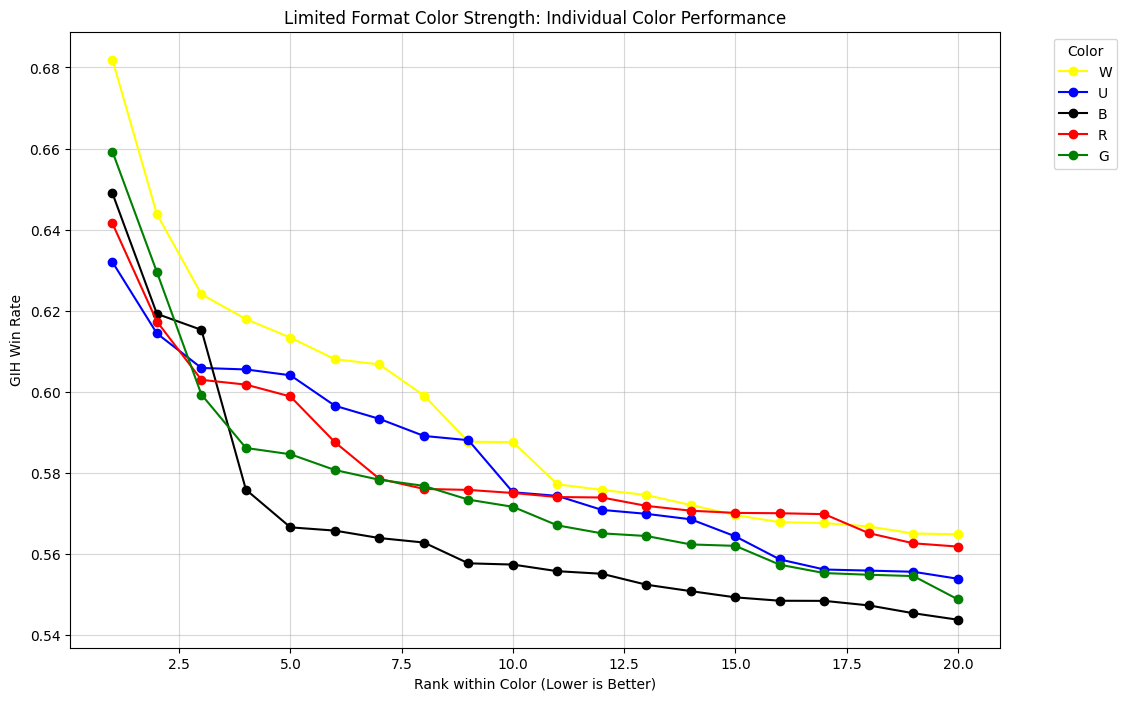

In [84]:

# Manually load color pair CSVs
df_w = pd.read_csv("DSK_color/DSK_W_win_rates.csv")
df_u = pd.read_csv("DSK_color/DSK_U_win_rates.csv")
df_b = pd.read_csv("DSK_color/DSK_B_win_rates.csv")
df_r = pd.read_csv("DSK_color/DSK_R_win_rates.csv")
df_g = pd.read_csv("DSK_color/DSK_G_win_rates.csv")

# Store them in a dictionary for easy iteration
color_dfs = {
   'W': df_w, 'U': df_u, 'B': df_b, 'R': df_r, 'G': df_g
}

# Define a color map
color_colors = {
    'W': 'yellow', 'U': 'blue', 'B': 'black', 'R': 'red', 'G': 'green'
}


plt.figure(figsize=(12, 8))

# Loop through each color DataFrame and plot it
for color, df in color_dfs.items():
    if 'game_in_hand_wr' in df:
        # Rank within each color based on win rate (1 is best)
        df = df.sort_values(by='game_in_hand_wr', ascending=False).reset_index(drop=True).head(20)
        df['rank_within_color'] = df.index + 1  # Rank starts from 1
        
        # Debug: print the color and the assigned color
        print(f"Plotting color {color} with color {color_colors.get(color, 'black')}")

        # Plot a line for this color
        plt.plot(df['rank_within_color'], df['game_in_hand_wr'], 
                 marker='o', label=color, color=color_colors.get(color, 'black'))

# Labels & Formatting
plt.xlabel('Rank within Color (Lower is Better)')
plt.ylabel('GIH Win Rate')
plt.title('Limited Format Color Strength: Individual Color Performance')
plt.legend(title="Color", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

                                     name colors  color_pairs  game_played_wr  \
0               Overlord of the Mistmoors      W  WU,WG,WB,WR        0.588884   
1                         Ghostly Dancers      W  WU,WG,WB,WR        0.575338   
2   Dollmaker's Shop // Porcelain Gallery      W  WU,WG,WB,WR        0.566081   
3                     Sheltered by Ghosts      W  WU,WG,WB,WR        0.571086   
4                Toby, Beastie Befriender      W  WU,WG,WB,WR        0.570660   
5                  Unidentified Hovership      W  WU,WG,WB,WR        0.565871   
6                    Optimistic Scavenger      W  WU,WG,WB,WR        0.571320   
7                      Enduring Innocence      W  WU,WG,WB,WR        0.565456   
8                   The Wandering Rescuer      W  WU,WG,WB,WR        0.552899   
9                          Splitskin Doll      W  WU,WG,WB,WR        0.569840   
10                         Ethereal Armor      W  WU,WG,WB,WR        0.557277   
11                          

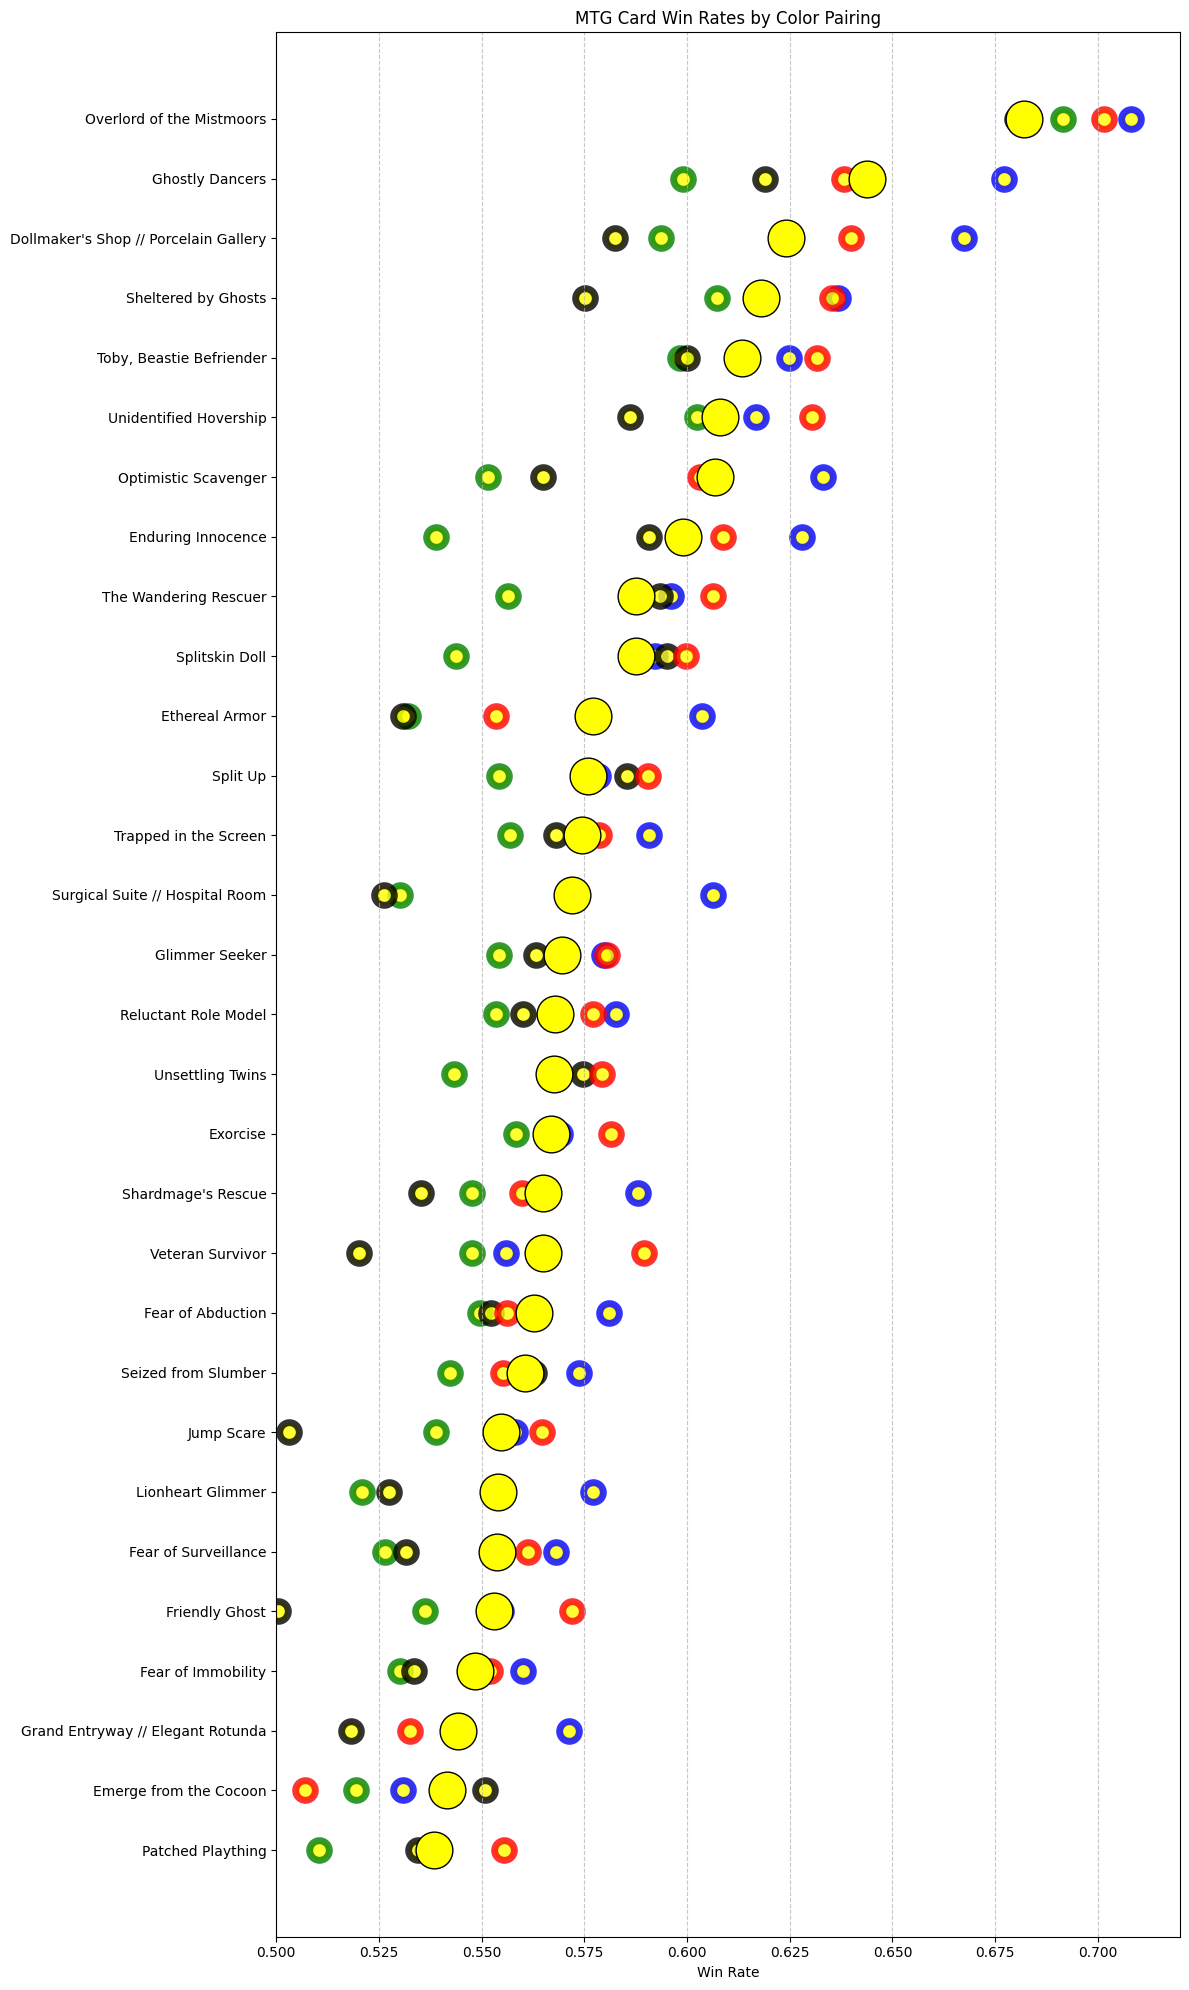

                                   name colors  color_pairs  game_played_wr  \
0             Overlord of the Floodpits      U  WU,UB,UG,UR        0.572619   
1                        Entity Tracker      U  WU,UB,UG,UR        0.564165   
2                    Enduring Curiosity      U  WU,UB,UG,UR        0.563141   
3                       Unnerving Grasp      U  WU,UB,UG,UR        0.567732   
4                    Silent Hallcreeper      U  WU,UB,UG,UR        0.559586   
5                     Fear of Isolation      U  WU,UB,UG,UR        0.565641   
6                      Abhorrent Oculus      U  WU,UB,UG,UR        0.561852   
7                     Floodpits Drowner      U  WU,UB,UG,UR        0.560963   
8              Stay Hidden, Stay Silent      U  WU,UB,UG,UR        0.558623   
9                          Glimmerburst      U  WU,UB,UG,UR        0.555390   
10       Bottomless Pool // Locker Room      U  WU,UB,UG,UR        0.546911   
11                   Cursed Windbreaker      U  WU,U

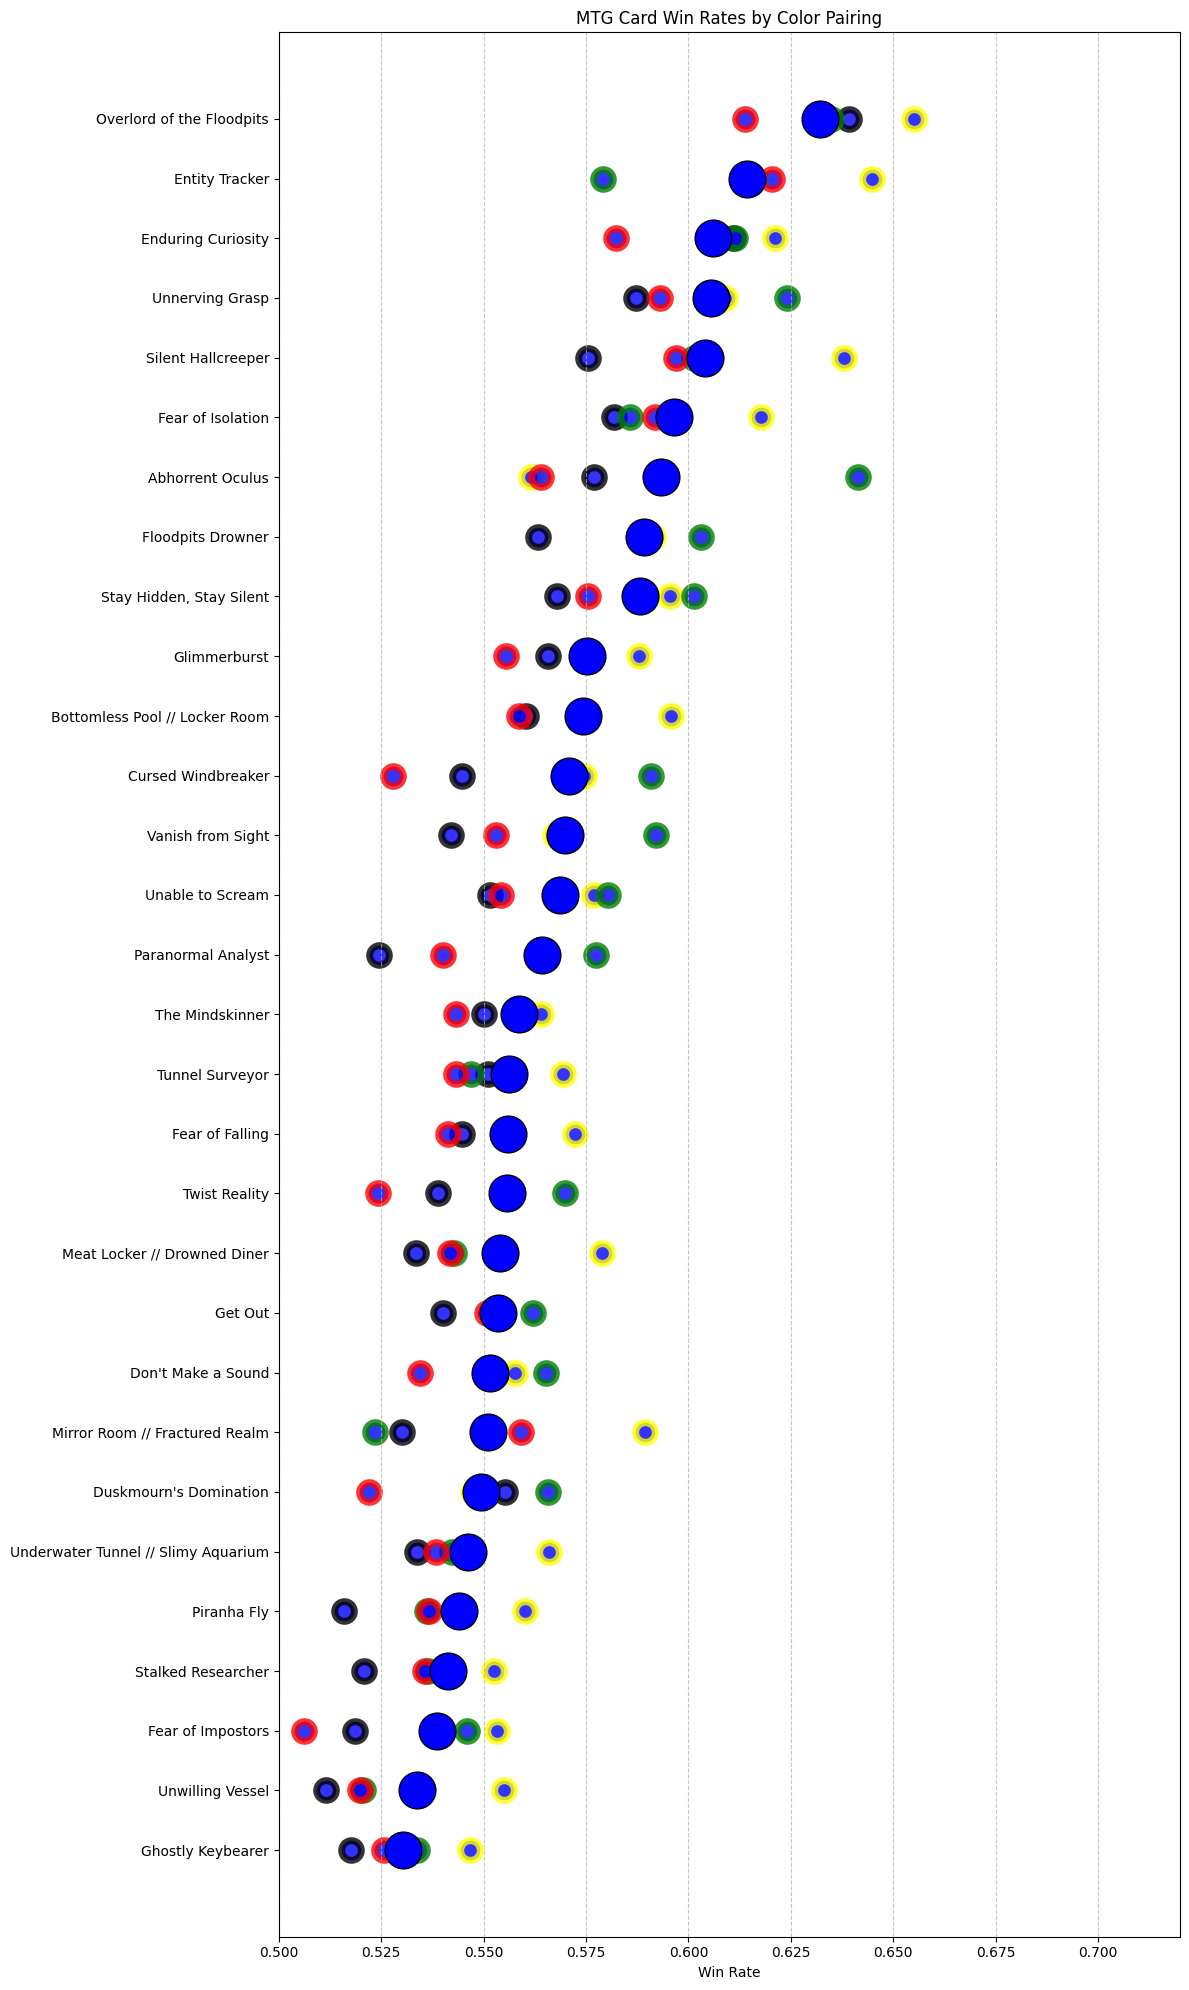

                              name colors  color_pairs  game_played_wr  \
0   Unholy Annex // Ritual Chamber      B  UB,BR,WB,BG        0.567396   
1         Overlord of the Balemurk      B  UB,BR,WB,BG        0.561966   
2              Unstoppable Slasher      B  UB,BR,WB,BG        0.558169   
3                   Nowhere to Run      B  UB,BR,WB,BG        0.540998   
4             Osseous Sticktwister      B  UB,BR,WB,BG        0.545063   
5                  Final Vengeance      B  UB,BR,WB,BG        0.540507   
6                Commune with Evil      B  UB,BR,WB,BG        0.533093   
7                  Come Back Wrong      B  UB,BR,WB,BG        0.530667   
8                Let's Play a Game      B  UB,BR,WB,BG        0.528482   
9   Funeral Room // Awakening Hall      B  UB,BR,WB,BG        0.527002   
10            Sporogenic Infection      B  UB,BR,WB,BG        0.533326   
11                   Innocuous Rat      B  UB,BR,WB,BG        0.540419   
12                     Live or Die    

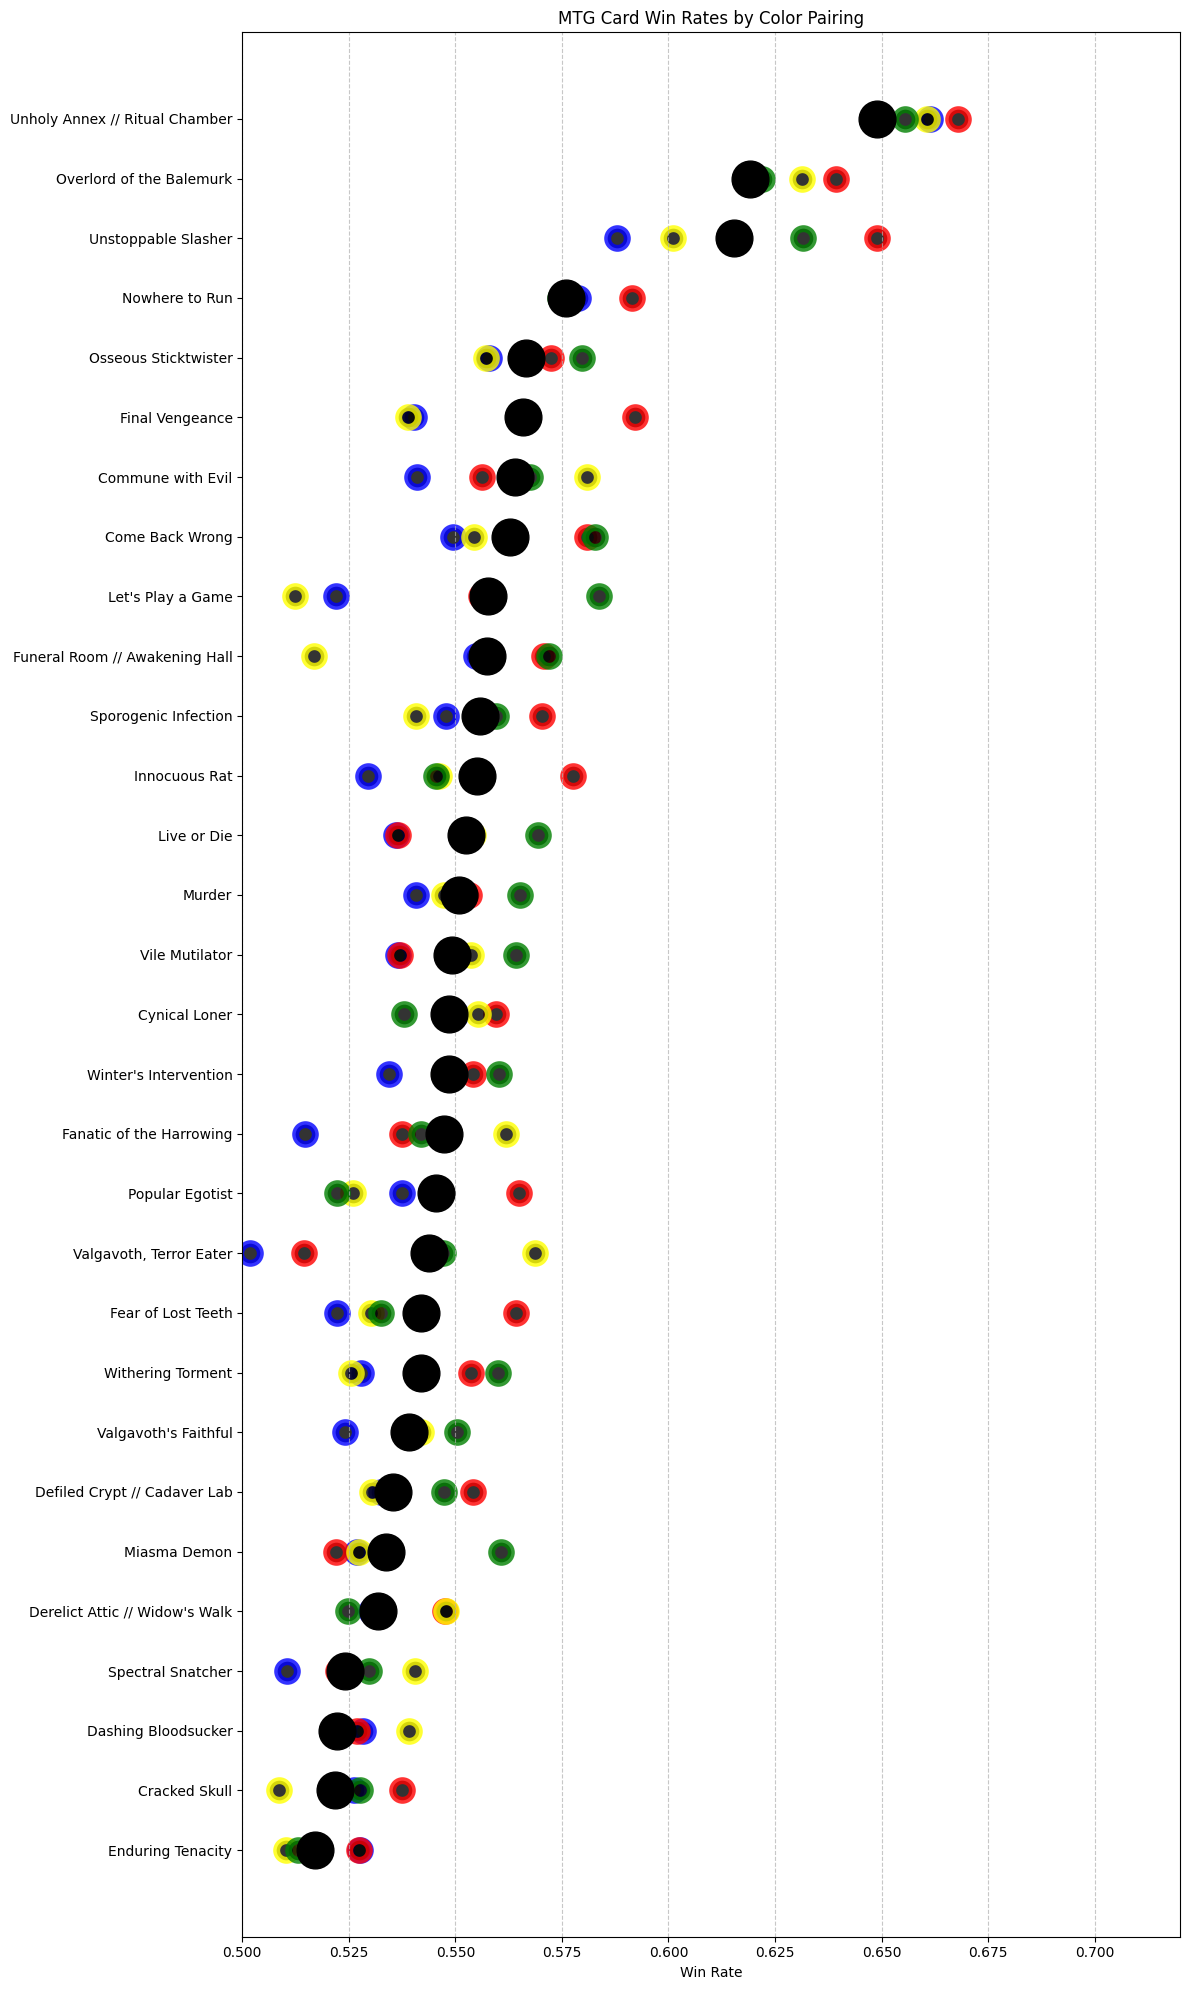

                                   name colors  color_pairs  game_played_wr  \
0          Overlord of the Boilerbilges      R  BR,RG,UR,WR        0.581353   
1                     Screaming Nemesis      R  BR,RG,UR,WR        0.573220   
2                The Rollercrusher Ride      R  BR,RG,UR,WR        0.556419   
3                              Chainsaw      R  BR,RG,UR,WR        0.562853   
4                   Fear of Missing Out      R  BR,RG,UR,WR        0.566024   
5                  Razorkin Hordecaller      R  BR,RG,UR,WR        0.565921   
6                    Betrayer's Bargain      R  BR,RG,UR,WR        0.558488   
7                            Piggy Bank      R  BR,RG,UR,WR        0.560809   
8                 Fear of Burning Alive      R  BR,RG,UR,WR        0.556322   
9                    Irreverent Gremlin      R  BR,RG,UR,WR        0.566510   
10                 Scorching Dragonfire      R  BR,RG,UR,WR        0.557036   
11  Painter's Studio // Defaced Gallery      R  BR,R

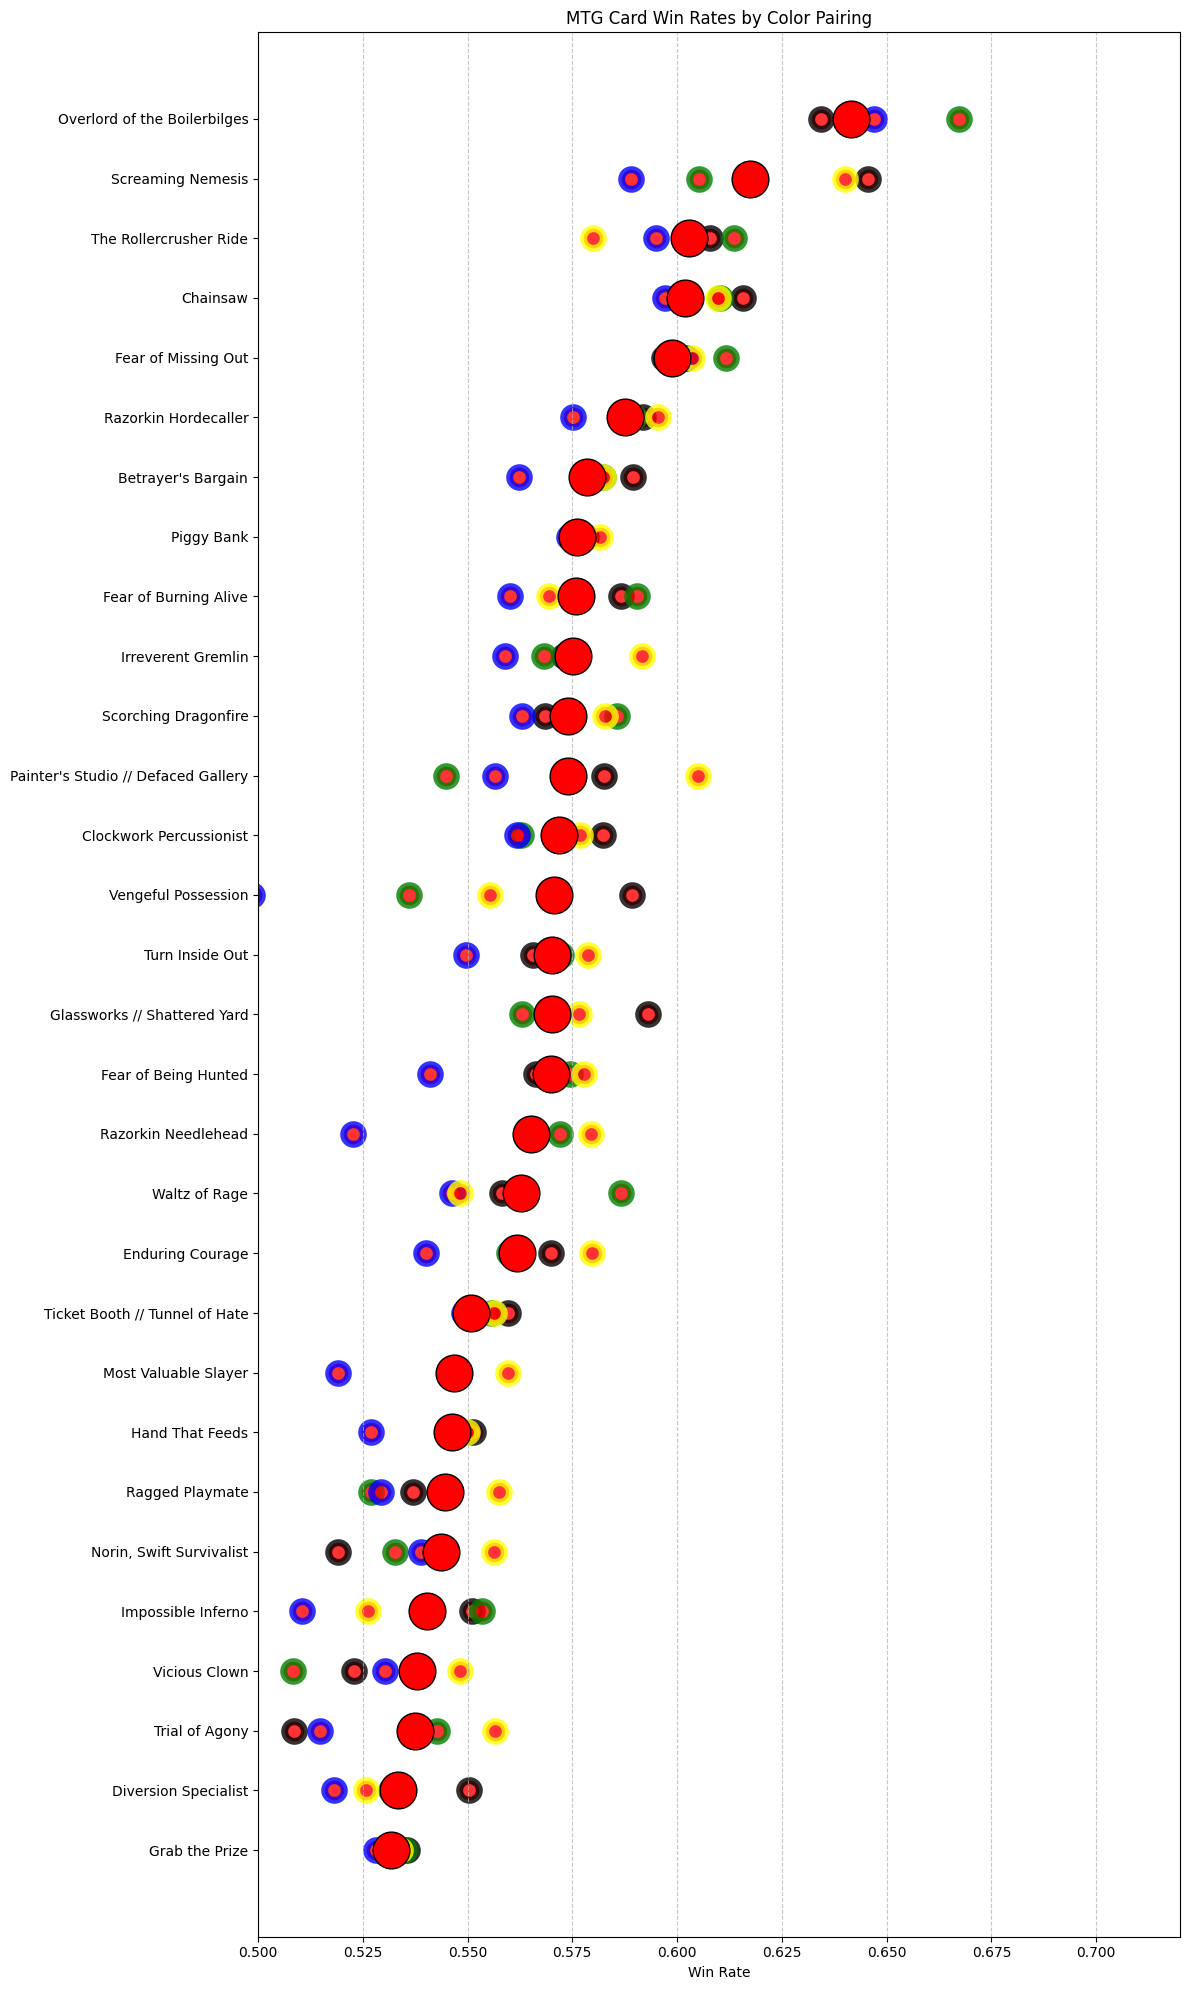

                            name colors  color_pairs  game_played_wr  \
0          Valgavoth's Onslaught      G  RG,WG,BG,UG        0.578408   
1            Tyvar, the Pummeler      G  RG,WG,BG,UG        0.573022   
2                 Under the Skin      G  RG,WG,BG,UG        0.562001   
3                Balustrade Wurm      G  RG,WG,BG,UG        0.561786   
4    Threats Around Every Corner      G  RG,WG,BG,UG        0.550716   
5                 Twitching Doll      G  RG,WG,BG,UG        0.547746   
6              Patchwork Beastie      G  RG,WG,BG,UG        0.560539   
7             Omnivorous Flytrap      G  RG,WG,BG,UG        0.552799   
8            Hauntwoods Shrieker      G  RG,WG,BG,UG        0.551455   
9          Spineseeker Centipede      G  RG,WG,BG,UG        0.551816   
10    Overlord of the Hauntwoods      G  RG,WG,BG,UG        0.538150   
11              Insidious Fungus      G  RG,WG,BG,UG        0.549819   
12             Enduring Vitality      G  RG,WG,BG,UG        0.53

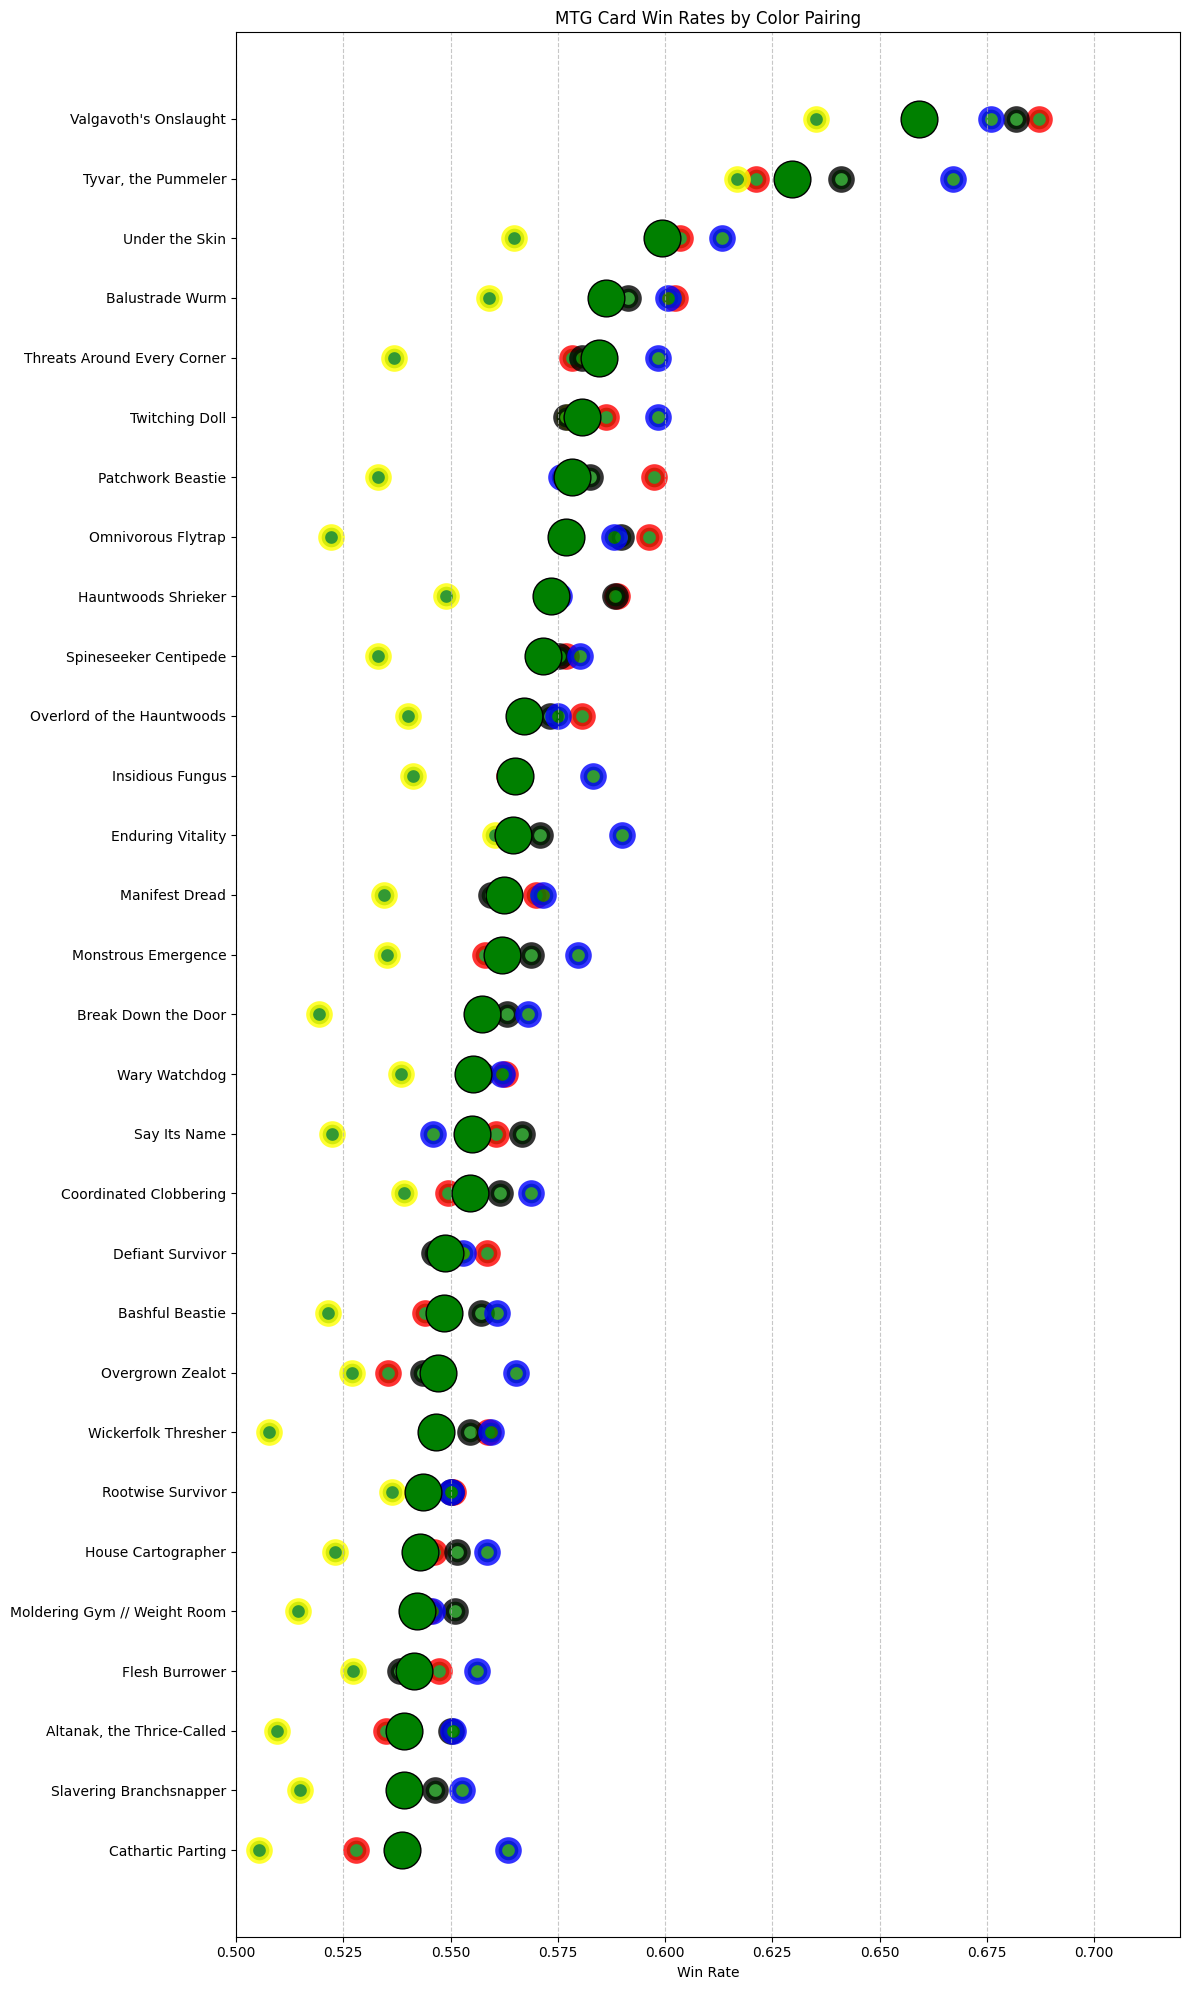

In [ ]:
# top 30 card in each color + their color-pair winrates

valid_colors = ['W', 'U', 'B', 'R', 'G']
for color in valid_colors:

    # top30 = wrdf.sort_values(by='game_played_wr', ascending=False).head(30)
    combined = pd.read_csv('DSK_data_combined.csv')

    monocolor = combined[combined['colors'].isin([color])]

    valid_color_pairs = ['WU', 'UB', 'BR', 'RG', 'WG', 'WB', 'BG', 'UG', 'UR', 'WR']
    for color_pair in valid_color_pairs:
        color_pair_df = pd.read_csv(f"DSK_color/DSK_{color_pair}_win_rates.csv")
        monocolor = monocolor.merge(color_pair_df[['name','game_in_hand_wr']],
                            how='left',
                            on='name',
                            suffixes=('', f'_{color_pair}'))


    monocolor = monocolor.sort_values(by='game_in_hand_wr', ascending=False)
    monocolor = monocolor.head(30)
    monocolor = monocolor.reset_index(drop=True)  # Reset the index to make sure it’s sequential

    monocolor.to_csv(f'DSK_color/DSK_top30_{color}.csv')
    print(monocolor)

    # Convert to pandas for easier plotting
    df_pandas = pd.DataFrame(monocolor)

    # Create a color mapping dictionary
    color_map = {
        'W': 'yellow',
        'U': 'blue',
        'B': 'black',
        'R': 'red',
        'G': 'green'
    }

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12,20))

    # Iterate through each row in the DataFrame
    for idx, row in df_pandas.iterrows():
        card_name = row['name']
        card_color = row['colors']
        
        # Get the inner color based on the card's color
        inner_color = color_map.get(card_color, 'darkgray')
        
        # Plot the general win rate
        if pd.notna(row['game_in_hand_wr']):
            ax.scatter(row['game_in_hand_wr'], idx, 
                    color=inner_color, 
                    s=700,
                    zorder=2,
                    edgecolors='black',
                    label='General WR' if idx == 0 else "")
        
        # Plot win rates for each color pairing
        for col in df_pandas.columns:
            if col.startswith('game_in_hand_wr_') and pd.notna(row[col]):
                # Get the color pairing from the column name
                color_pairing = col.replace('game_in_hand_wr_', '')
                
                # Determine the edge color based on the card's color and the pairing
                if len(color_pairing) == 2:
                    color1, color2 = color_pairing[0], color_pairing[1]
                    
                    # If the card is one of the colors in the pairing, use the other color
                    if card_color == color1:
                        edge_color = color_map.get(color2)
                    elif card_color == color2:
                        edge_color = color_map.get(color1)
                    else:
                        # Skip this pairing if the card color isn't in the pairing
                        continue
                else:
                    # Skip invalid pairings
                    continue
                
                # Only plot if we have a valid edge color
                if edge_color:
                    ax.scatter(row[col], idx, 
                            color=inner_color, 
                            edgecolor=edge_color,
                            s=200,
                            alpha=0.8,
                            linewidth=5,
                            zorder=1,
                            label=color_pairing if idx == 0 else "")

    # Add card names to the y-axis
    plt.yticks(range(len(df_pandas)), df_pandas['name'])

    ax.invert_yaxis()

    # Set the x-axis limits
    plt.xlim(0.50, 0.72)

    # Add labels and title
    plt.xlabel('Win Rate')
    plt.title('MTG Card Win Rates by Color Pairing')

    # Add gridlines for better readability
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Adjust layout to make room for card names
    plt.tight_layout()

    # Show the plot
    plt.show()

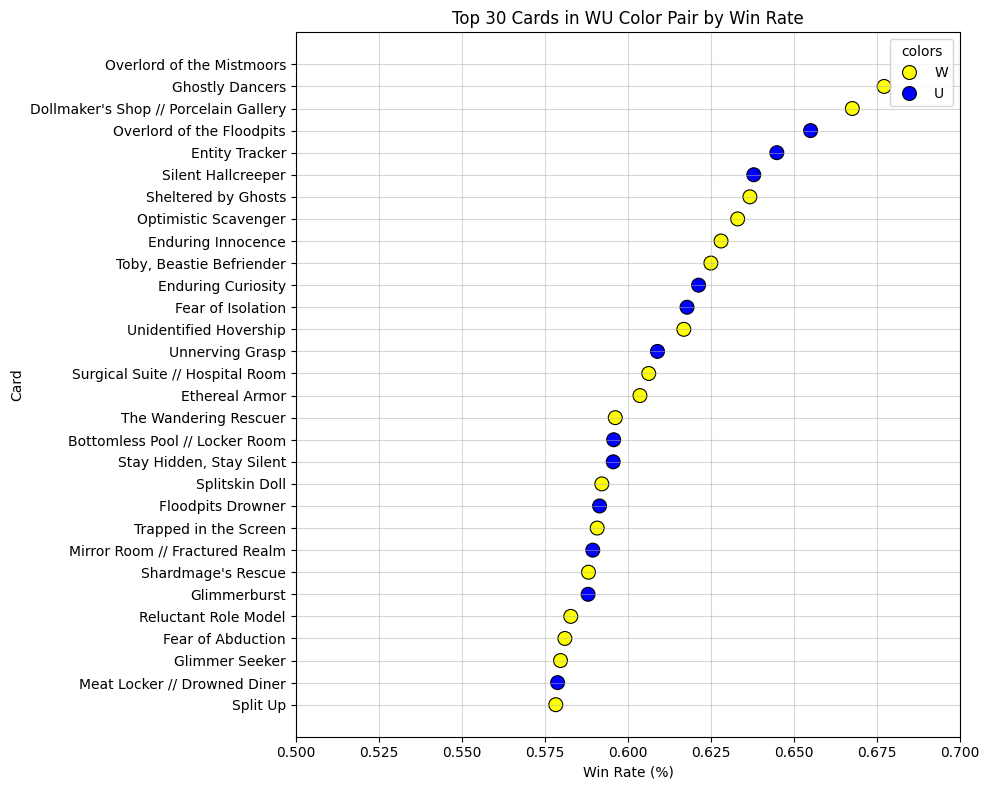

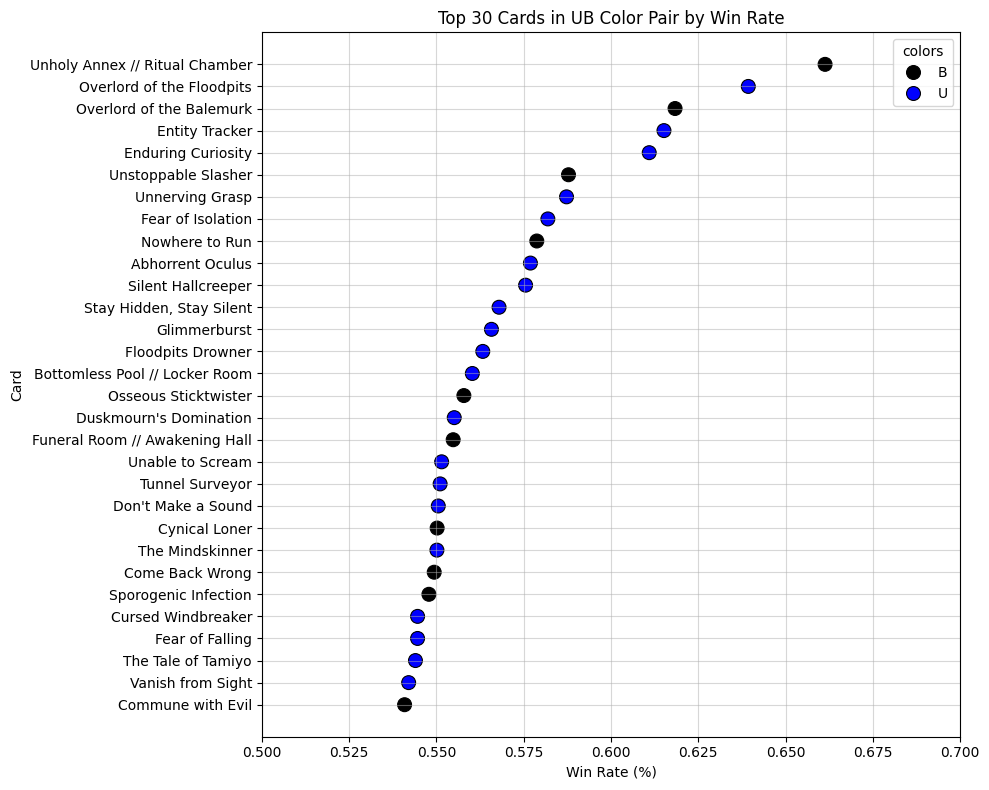

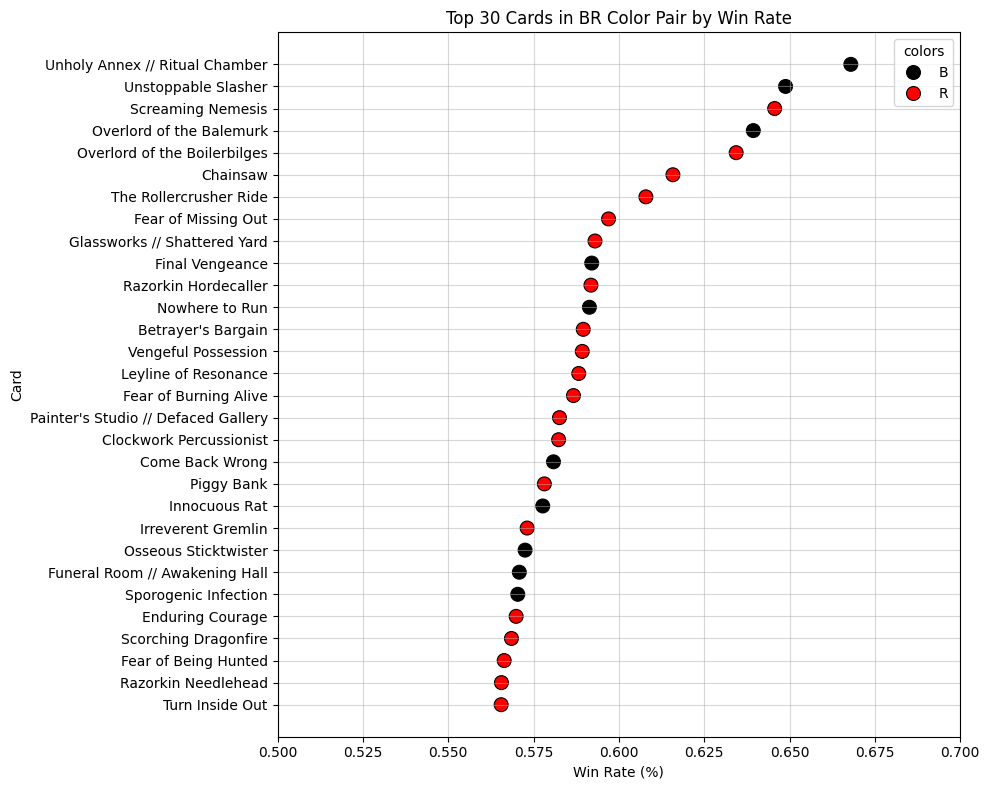

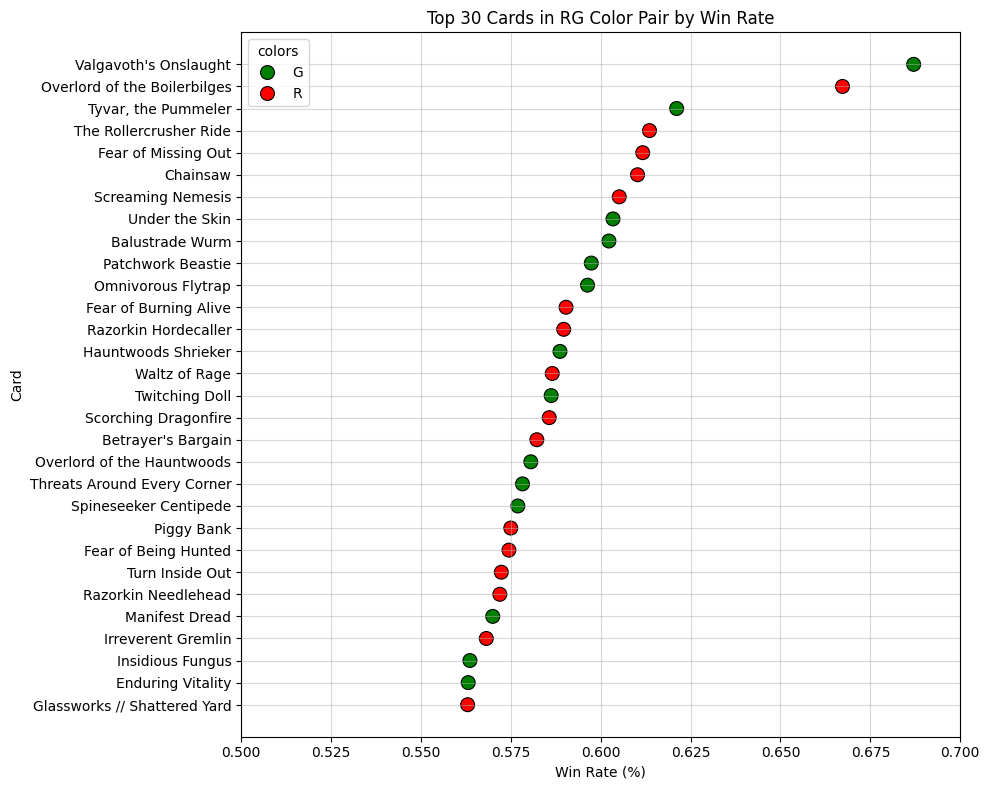

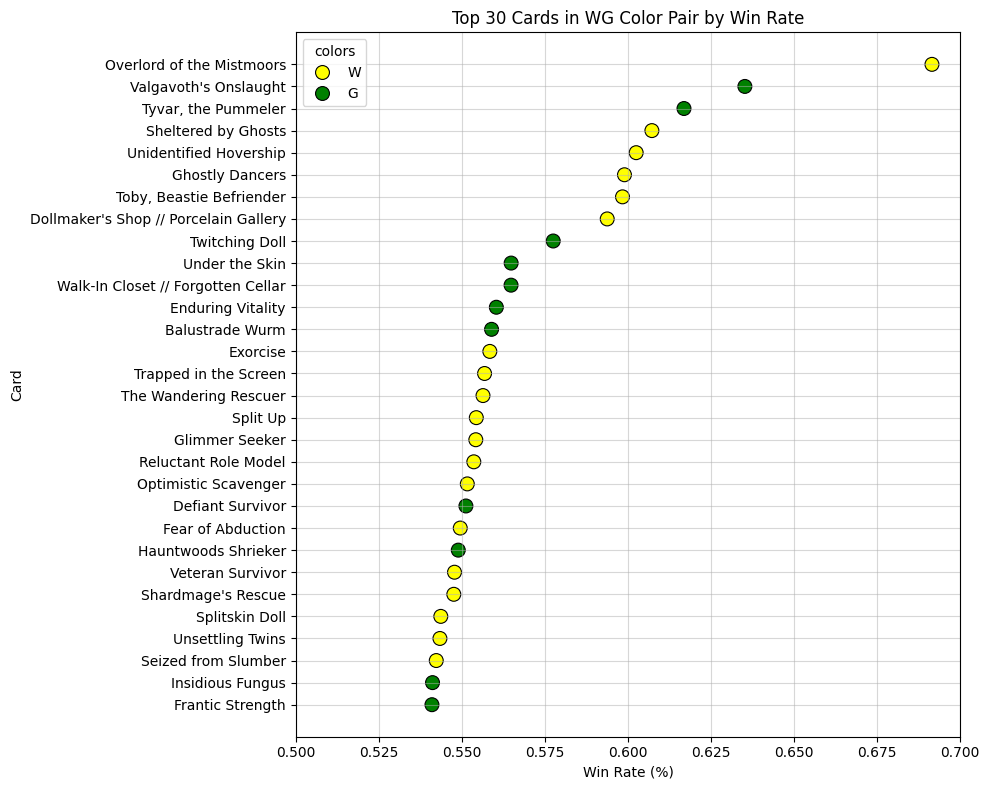

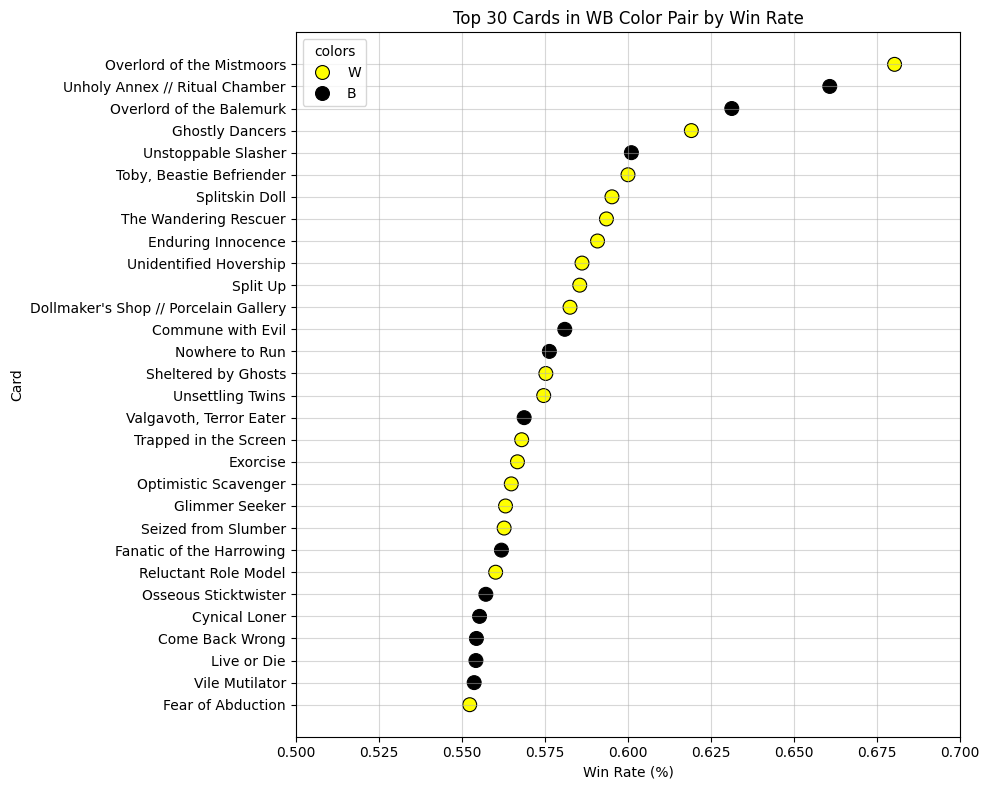

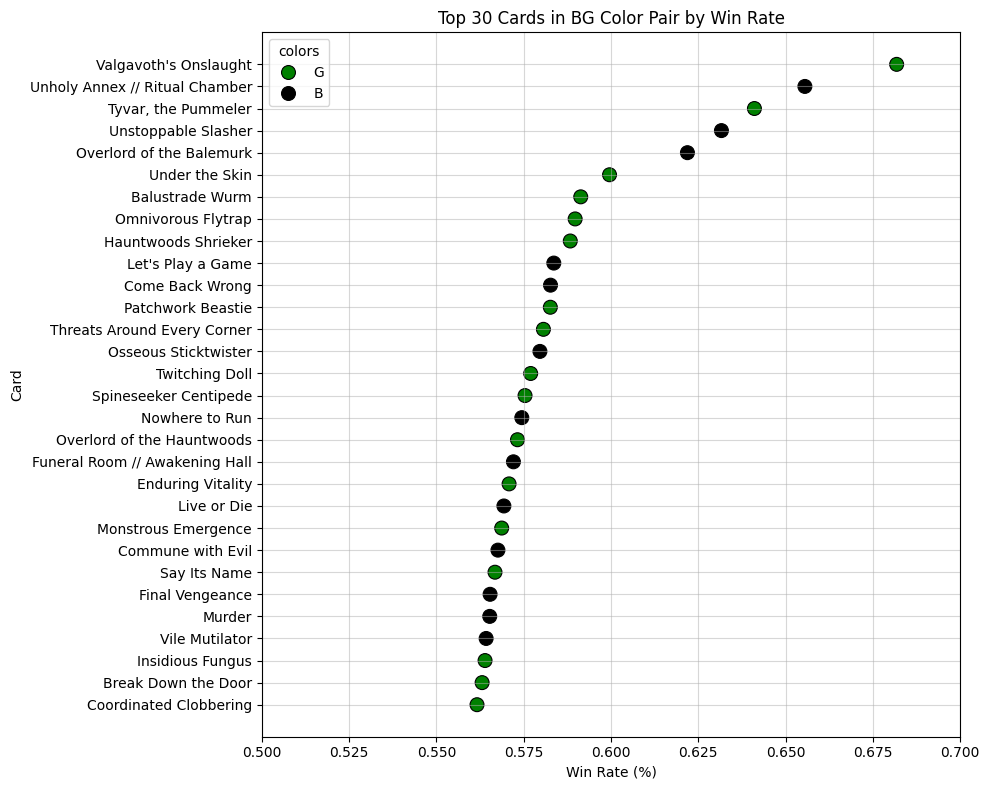

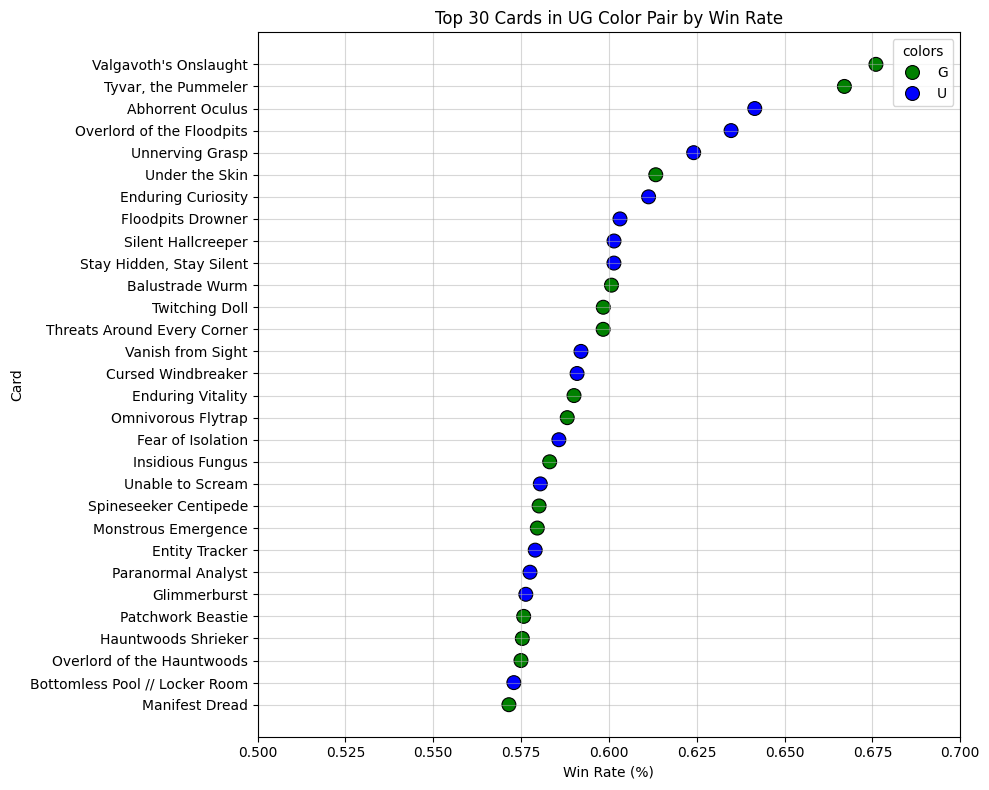

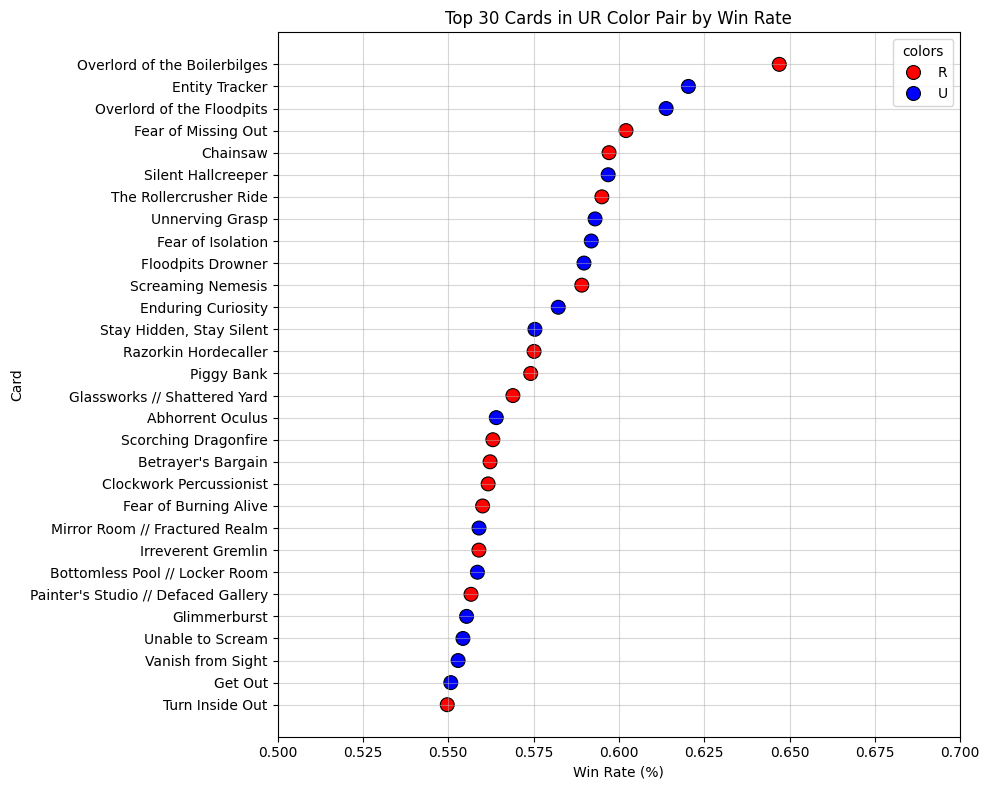

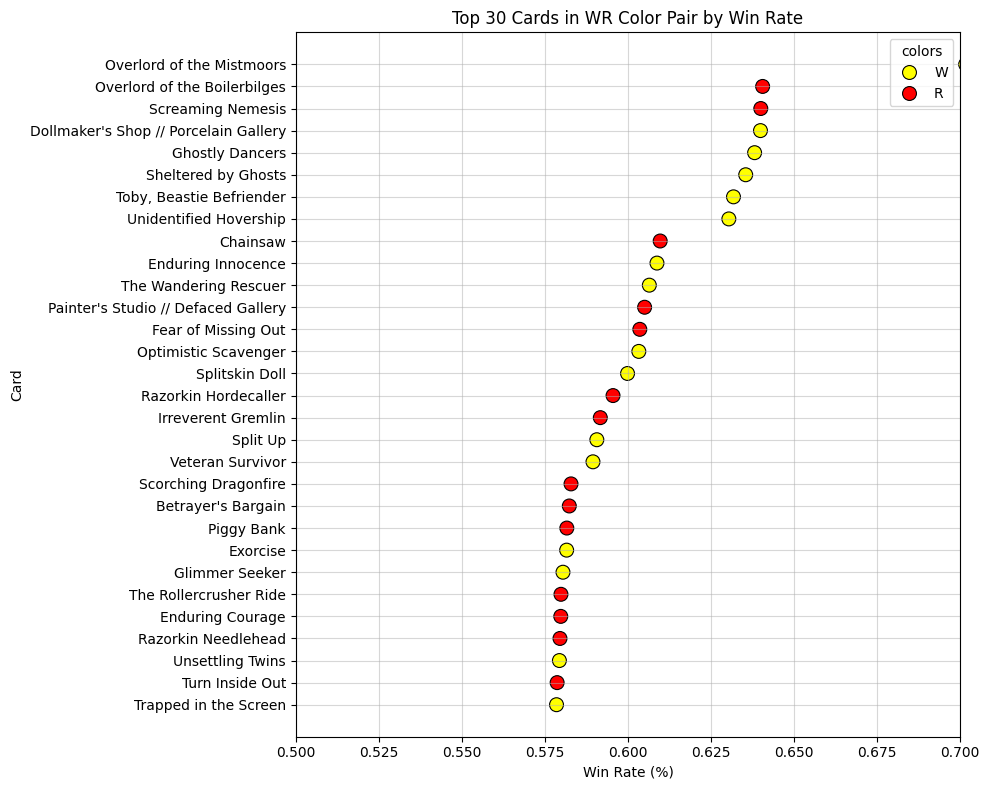

In [2]:

valid_color_pairs = ['WU', 'UB', 'BR', 'RG', 'WG', 'WB', 'BG', 'UG', 'UR', 'WR']
for color_pair in valid_color_pairs:
    whitered = pd.read_csv(f"DSK_color/DSK_{color_pair}_win_rates.csv")
    top30_color_pair = whitered.sort_values(by='game_in_hand_wr', ascending=False).head(30)
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=top30_color_pair, 
                    x='game_in_hand_wr',  # Use win rate for x-axis
                    y='name',              # Use card names for y-axis
                    hue='colors',          # Color by the card's color
                    s = 100,
                    palette={'R': 'red', 'U': 'blue', 'G': 'green', 'W': 'yellow', 'B': 'black'}, 
                    edgecolor='black',     # Add black edge around dots
                    marker='o')            # Circle markers

    # Set labels and title
    plt.xlabel('Win Rate (%)')
    plt.ylabel('Card')
    plt.title(f'Top 30 Cards in {color_pair} Color Pair by Win Rate')
    plt.grid(True, alpha=0.5)
    plt.xlim(0.50, 0.70)

    # Show the plot
    plt.tight_layout()
    plt.savefig(f'Analysis_Images/DSK_{color_pair}_breakdown.png')
    plt.show()